# Projet Commande Entreprise - Projet 23 : Traitement d'Images Microscopiques par Intelligence Artificielle
## Partenariat avec Cobalt Contraception

### Contexte et Objectifs du Projet

Ce projet s'inscrit dans le cadre de l'UE Projet Commande Entreprise, semestre 7, formation ingénieur généraliste FISE IMT Atlantique. Il est réalisé en partenariat avec **Cobalt Contraception** (135 rue Claude Chappe, 29280, Plouzané), sous la supervision de **Mme Eléonore Abadie** (Présidente, contact@cobalt-contraception.com).

L'objectif final de notre partenaire est la mise au point d'un **dispositif de contraception masculine** naturel, réversible, et non-invasif. Pour favoriser l'acceptation de cette méthode, il est essentiel de permettre aux utilisateurs de réaliser facilement un **spermogramme à domicile**. Notre projet consiste à développer une solution de traitement d'image permettant de mesurer la concentration et la mobilité des spermatozoïdes via un système optique intégré dans un boîtier connecté à la caméra d'un smartphone.

### Description du Projet

Notre mission dans le cadre de ce projet est de concevoir un **premier prototype d'algorithme** capable de compter et analyser des cellules dans des images microscopiques. Cet algorithme sera optimisé pour fonctionner sur un environnement Linux embarqué, notamment sur une Raspberry Pi, et vise deux fonctionnalités principales :

1. **Détection et comptage des cellules** dans les images pour calculer leur concentration.
2. **Analyse de la mobilité cellulaire** dans des vidéos (futur développement).

### Livrables

- Algorithme de détermination de la concentration des cellules (60 %)
- Intégration de l’algorithme sur Raspberry Pi (30 %)
- Rapport d'analyse des différentes approches algorithmiques (10 %)

### Équipe Projet

- **Étudiants** : Khalil ABDELHEDI, Corentin BOUTAULT, Iyed DAMMAK (auteur du notebook), Thomas FAVRE, Skander MAHJOUB, Noah SCHOUAME, Fabien SENEQUIER
- **Conseiller** : Jack Bourdin White, qui nous a apporté son expertise et ses conseils précieux
- **Tuteur entreprise** : Mme Eléonore Abadie, Présidente, eleonore@cobalt-contraception.com
- **Tuteur académique** : Mme LANGLAIS Charlotte ,IMT Atlantique

### Mots-Clés
Computer vision, Image segmentation, Apprentissage profond, Raspberry Pi, Spermogramme à domicile

---



# CNN for counting 
This fil is for CNN application
This notebook presents a CNN-based approach developed for COBALT to automate sperm cell counting in microscopic images. The goal is to build a reliable model that can accurately detect and count cells, streamlining the fertility analysis process.

We’ll cover data preparation, model design, and evaluation to achieve an efficient and accurate cell-counting solution.

---

**Initialization and Importing Libraries and Tools** 

In [342]:
# Standard libraries
import sys
import os

# Adding a custom toolkit repository to the system path
# This allows for easy importing of custom tools from 'tool_kit' located in a parent directory
#path_to_tool_kit = os.path.abspath('/homes/i23damma/Bureau/Cobalt/cobalt')
path_to_tool_kit = os.path.abspath('..')
if path_to_tool_kit not in sys.path:
    sys.path.append(path_to_tool_kit)

# Import custom toolkit functions (e.g., utility functions or model-related functions)
import tool_kit as tk
#sys.path.append('/homes/i23damma/Bureau/Cobalt/cobalt/CNN')
# Data manipulation and numerical operations
import numpy as np  # To install: `pip install numpy`
import pandas as pd  # To install: `pip install pandas`

# PyTorch library for image transformations
import torchvision.transforms as transforms  # To install: `pip install torchvision`

# Library for data visualization
import matplotlib.pyplot as plt  # To install: `pip install matplotlib`

# Importing PyTorch summary for model inspection
from torchsummary import summary  # To install: `pip install torchsummary`

# Core PyTorch libraries for deep learning
import torch  # To install: `pip install torch`
import torch.nn as nn
import torch.nn.functional as F

# Additional utility functions and tools
from torch.utils.data.sampler import SubsetRandomSampler
from costumize_data import CustomDataset  # Custom dataset handler

import seaborn as sns

**Loading and Displaying Dataset Information**

In [343]:
# Setting the path to the dataset using a function from the custom toolkit
# This allows the toolkit to locate and access the dataset files.
#tk.set_path_to_dataset('/homes/i23damma/Bureau/Cobalt/cobalt/')
tk.set_path_to_dataset('..')

# Loading the images and mask data using functions from the toolkit
images = tk.load_data_image()
mask = tk.load_data_mask()
# Displaying the first few entries of each DataFrame to understand the data structure
print(' images =\n', images.head())
print(' mask =\n', mask.head())
# 'mask' DataFrame:# - Type: pandas DataFrame# - Contains: Each entry has the image ID and the count of cells present in the image.
# 'images' DataFrame:# - Type: pandas DataFrame # - Contains: Each entry has the image ID, cell count, mask availability (boolean), and blur status.


 images =
                             image_id  nb_cells mask  blur
0  SIMCEPImages_A01_C1_F1_s01_w1.TIF         1  yes     1
1  SIMCEPImages_A01_C1_F1_s01_w2.TIF         1  yes     1
2  SIMCEPImages_A01_C1_F1_s02_w1.TIF         1  yes     1
3  SIMCEPImages_A01_C1_F1_s02_w2.TIF         1  yes     1
4  SIMCEPImages_A01_C1_F1_s03_w1.TIF         1  yes     1
 mask =
                             image_id  nb_cells
0  SIMCEPImages_A01_C1_F1_s01_w1.TIF         1
1  SIMCEPImages_A01_C1_F1_s01_w2.TIF         1
2  SIMCEPImages_A01_C1_F1_s02_w1.TIF         1
3  SIMCEPImages_A01_C1_F1_s02_w2.TIF         1
4  SIMCEPImages_A01_C1_F1_s03_w1.TIF         1


**Selecting and Filtering the Dataset**

In [344]:
mask_or_image = 'mask'  # Variable to determine which dataset to use

if mask_or_image == 'mask':
    df = mask  # If 'mask' is selected, assign the mask DataFrame to df
    # Filter the rows in the DataFrame where 'image_id' contains 'w1' (case insensitive)
    #df = df[df['image_id'].str.contains("w1", case=False, na=False)]
else:
    df = images.copy()  # If 'image' is selected, create a copy of the images DataFrame
    # Remove the 'blur' and 'mask' columns from the DataFrame
    #df.drop(columns=['blur', 'mask'], inplace=True) 
    # Uncomment the following line to filter images by 'w1' if needed
    # df = df[df['image_id'].str.contains("w1", case=False, na=False)]



df  # Display the resulting DataFrame


,image_id,nb_cells
0,SIMCEPImages_A01_C1_F1_s01_w1.TIF,1
1,SIMCEPImages_A01_C1_F1_s01_w2.TIF,1
2,SIMCEPImages_A01_C1_F1_s02_w1.TIF,1
3,SIMCEPImages_A01_C1_F1_s02_w2.TIF,1
4,SIMCEPImages_A01_C1_F1_s03_w1.TIF,1
...,...,...
1195,SIMCEPImages_A24_C100_F1_s23_w2.TIF,100
1196,SIMCEPImages_A24_C100_F1_s24_w1.TIF,100
1197,SIMCEPImages_A24_C100_F1_s24_w2.TIF,100
1198,SIMCEPImages_A24_C100_F1_s25_w1.TIF,100


**Data Normalization**

In [345]:
nb_classe=100
mean_label= 0 #df['nb_cells'].mean()
std_label = 1#df['nb_cells'].std()
# Centralisation et normalisation de la colonne 'label'
df['nb_cells'] = (df['nb_cells'] - mean_label) / std_label

Text(0, 0.5, 'Frequency')

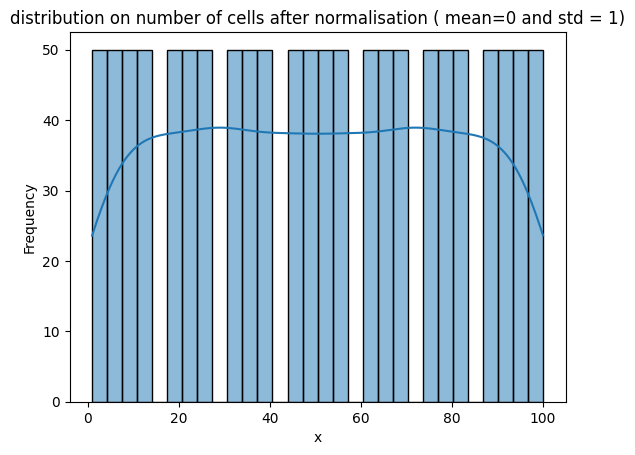

In [346]:


sns.histplot(df['nb_cells'], bins=30, kde=True)  # Plot a histogram with a kernel density estimate (KDE)
plt.title(f'distribution on number of cells after normalisation ( mean={mean_label} and std = {std_label})')  # Set the title of the plot
plt.xlabel('x')  # Label the x-axis
plt.ylabel('Frequency')  # Label the y-axis

**Splitting the Dataset into Training and Testing Sets**

In [347]:
# Set the fraction of data to be used for testing
frac = 0.3  # 20% of the data will be used for the test set
# Sample a subset of the DataFrame for testing without replacement
df_test = df.sample(frac=frac, replace=False, random_state=42)
# Create the training set by dropping the test set entries from the original DataFrame. Then shuffle the remaining data to create the training set
df_train = df.drop(df_test.index).sample(frac=1, random_state=42)

print('len(df) =', len(df))  # Total number of samples in the original DataFrame
print('len(df_train) =', len(df_train))  # Number of samples in the training set
print('len(df_test) =', len(df_test))  # Number of samples in the test set

print('df_train =\n', df_train.head())  # Show the first few rows of the training DataFrame
print('df_test =\n', df_test.head())  # Show the first few rows of the testing DataFrame


len(df) = 1200
len(df_train) = 840
len(df_test) = 360
df_train =
                                  image_id  nb_cells
1000   SIMCEPImages_A21_C87_F1_s01_w1.TIF      87.0
1165  SIMCEPImages_A24_C100_F1_s08_w2.TIF     100.0
41      SIMCEPImages_A01_C1_F1_s21_w2.TIF       1.0
866    SIMCEPImages_A18_C74_F1_s09_w1.TIF      74.0
143    SIMCEPImages_A03_C10_F1_s22_w2.TIF      10.0
df_test =
                                  image_id  nb_cells
1178  SIMCEPImages_A24_C100_F1_s15_w1.TIF     100.0
865    SIMCEPImages_A18_C74_F1_s08_w2.TIF      74.0
101    SIMCEPImages_A03_C10_F1_s01_w2.TIF      10.0
439    SIMCEPImages_A09_C35_F1_s20_w2.TIF      35.0
58      SIMCEPImages_A02_C5_F1_s05_w1.TIF       5.0


**Displaying Dataset Dimensions**

In [348]:
# Print the shape of the DataFrame
print(f"DataFrame shape: {df.shape}")
# Print the length of the training DataFrame
print(f"Number of training samples: {len(df_train)}")

DataFrame shape: (1200, 2)
Number of training samples: 840


**Displaying Sample Images with Cell Count Annotations**

In [349]:
# Set the image height and width
IMG_HEIGHT = 128
IMG_WIDTH = 128
# Assign the training DataFrame to Matrix
Matrix = df_train
# Number of images to show
n_img_to_show = 8
# Create a figure with a specified size
fig = plt.figure(figsize=(15, 5*n_img_to_show ))
# Create a list of indices based on the length of the Matrix
indices = list(range(len(Matrix)))
# Shuffle the indices randomly
np.random.shuffle(indices)
# Loop through the number of images to show
for i in range(n_img_to_show):
    # Add a subplot to the figure
    ax = fig.add_subplot( n_img_to_show // 2,2, i + 1, xticks=[], yticks=[])
    # Get the image using the tk.get_image function and display it
    ax.imshow(np.squeeze(tk.get_image(
        img_id=Matrix['image_id'].iloc[indices[i]],
        img_height=IMG_HEIGHT,
        img_width=IMG_WIDTH,
        mask_or_image=mask_or_image
    )), cmap='gray')
    # Set the title of the subplot
    ax.set_title(f'image {indices[i]} from the folder {mask_or_image} containing {int((Matrix["nb_cells"].iloc[indices[i]])*std_label+mean_label)} cells')
# Show the figure
plt.show()

KeyboardInterrupt: 

**Data Loader Creation for Training, Validation, and Testing**

In [ ]:
# Define batch size and validation size
batch_size = 20  # Number of samples per batch to load  # mettre en puissance de 2 #plus batch size est grand plus learn rate est peut etre elevée 
valid_size = 0.25  # Percentage of training set to use as validation

# Function to create data loaders for training, validation, and testing
def create_data_loaders(batch_size, valid_size, train_data, test_data):
  # Create a data loader for the test dataset
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
  # Generate a list of indices for the training data and shuffle them
  indices = list(range(len(train_data)))
  np.random.shuffle(indices)
  # Calculate the split index for validation data
  split = int(np.floor(valid_size * len(train_data)))
  # Split the indices into training and validation indices
  train_indexes, valid_indexes = indices[split:], indices[:split]
  # Create samplers for validation and training data
  valid_samplers = SubsetRandomSampler(valid_indexes)
  train_samplers = SubsetRandomSampler(train_indexes)
  # Create data loaders for validation and training data using the samplers
  valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_samplers)
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_samplers)
  # Return the data loaders
  return train_loader, valid_loader, test_loader




**Image Transformation and DataLoader Setup**

In [ ]:
# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH))  # Resize the image to the desired dimensions
])
# Create the training dataset using the custom dataset class and the defined transformation
train_data = CustomDataset(df_train, transform=transform)
train_data.set_path_to_dataset('..')  # Set the path to the dataset for the training data
# Create the testing dataset using the custom dataset class and the defined transformation
test_data = CustomDataset(df_test, transform=transform)
test_data.set_path_to_dataset('..')  # Set the path to the dataset for the testing data
# Create data loaders for training, validation, and testing datasets
train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data)

In [ ]:
print(train_data.__getitem__(100)[0])
torch.max(train_data.__getitem__(100)[0])

tensor([[[0.0021, 0.0008, 0.0039,  ..., 0.1301, 0.0080, 0.0068],
         [0.0017, 0.0022, 0.0071,  ..., 0.2547, 0.0157, 0.0079],
         [0.0028, 0.0068, 0.0121,  ..., 0.3191, 0.0210, 0.0072],
         ...,
         [0.0021, 0.0052, 0.0036,  ..., 0.0078, 0.0213, 0.0273],
         [0.0031, 0.0043, 0.0034,  ..., 0.0050, 0.0036, 0.0082],
         [0.0029, 0.0037, 0.0023,  ..., 0.0089, 0.0094, 0.0134]]])


tensor(0.8643)

**Training Function for Neural Network**

In [ ]:


def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer, name):
  """
    Train and validate the model.

    Parameters:
    n_epochs (int): Number of epochs to train the model.
    train_loader (DataLoader): DataLoader for the training data.
    valid_loader (DataLoader): DataLoader for the validation data.
    model (nn.Module): The neural network model to train.
    criterion (nn.Module): The loss function.
    optimizer (torch.optim.Optimizer): The optimizer.

    Returns:
    train_losses (list): List of training losses for each epoch.
    valid_losses (list): List of validation losses for each epoch.
    """
  train_losses, valid_losses = [], []
  # initialize tracker for minimum validation loss
  valid_loss_min = np.inf  # set initial "min" to infinity

  for epoch in range(n_epochs):
      
      train_loss, valid_loss = 0, 0 # monitor losses

      # train the model
      model.train() # prep model for training
      for data, label in train_loader:
          
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.float32)
          
          optimizer.zero_grad()
          output=model(data)
          #print('label=',label,'\n','output=',output)
          output= output.view(-1)
          loss=criterion(output,label)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * data.size(0) # update running training loss
      
      # validate the model
      model.eval()
      for data, label in valid_loader:
        data = data.to(device=device, dtype=torch.float32)
        label = label.to(device=device, dtype=torch.float32)

        with torch.no_grad():
          output=model( data)
          
        output= output.view(-1)
        loss=criterion(label,output)
        valid_loss += loss.item() * data.size(0)
    
      # calculate average loss over an epoch
      train_loss /= len(train_loader.sampler)
      valid_loss /= len(valid_loader.sampler)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)

      print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))
      
      # save model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), name)
          valid_loss_min = valid_loss

  return train_losses, valid_losses

**Evaluation Function for Neural Network**

In [ ]:
def evaluation(model, test_loader, criterion):

  # initialize lists to monitor test loss and accuracy
  test_loss = 0.0
  class_correct = list(0. for i in range(101))
  class_total = list(0. for i in range(101))
  #creat a empty dict of 101 elements
  dict={}
  for i in range(1,101):
      dict[i]=[]
  model.eval() # prep model for evaluation
  for data, label in test_loader:
      ratio= nb_classe-1+np.exp(1)
      label1 = torch.tensor([ [np.exp(1)/ratio if i+1==label[j] else 0 for i in range(nb_classe) ] for j in range(data.size(0))])
      data = data.to(device=device, dtype=torch.float32)
      label1 = label1.to(device=device, dtype=torch.float32)
      label.to(device=device, dtype=torch.float32)
      with torch.no_grad():
          output = model(data) # forward pass: compute predicted outputs by passing inputs to the model
          output.to(device=device, dtype=torch.float32)
      loss = criterion(output, label1)

      test_loss += loss.item()*data.size(0)
      pred = torch.argmax(output, dim=1)
      
      correct =[ 1 if (pred[i]-label[i]<2) and (pred[i]-label[i]>-2) else 0 for i in range( data.size(0))]
      #correct = np.squeeze(pred.eq(label.data.view_as(pred))) # compare predictions to true label
      # calculate test accuracy for each object class
      for i in range(len(label)):
          number_expected = int(label.data[i]*std_label+mean_label)
          
          class_correct[number_expected] += correct[i]
          class_total[number_expected] += 1
          
          
          
          dict[number_expected].append(int(pred[i]))
      
  
  #print and return the results
  for i in range(100):
     if class_total[i] > 0 : 
        print( 'For the true value ', i, 'the predicted values are ', dict[i])
  # calculate and print avg test loss
  test_loss = test_loss/len(test_loader.sampler)
  print('test Loss: {:.6f}\n'.format(test_loss))
  for i in range(100):
      if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        print('Test accuracy of %1s: %2.2f%% (%2d/%2d)' % (str(i), accuracy, np.sum(class_correct[i]), np.sum(class_total[i])))
      #else: 
        #print('Test accuracy of %1s: N/A (0/0)' % str(i))

  print('\ntest accuracy (overall): %2.2f%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

**KAGGLE_CNN Class Overview**

In [ ]:


class KAGGLE_CNN(nn.Module):
    def __init__(self, img_height, img_width, img_channels=1, padding=1, kernel_size=3, pool_size=2,
                 first_filters=32, second_filters=64, third_filters=128, 
                 dropout_conv=0.0, dropout_dense=0.0):
        super(KAGGLE_CNN, self).__init__()

        # Layer 1: Initial Conv layer with padding
        self.conv1 = nn.Conv2d(in_channels=img_channels, out_channels=first_filters,
                               kernel_size=kernel_size, padding=padding)
        self.conv2 = nn.Conv2d(in_channels=first_filters, out_channels=first_filters,
                               kernel_size=kernel_size, padding=padding)
        self.conv3 = nn.Conv2d(in_channels=first_filters, out_channels=first_filters,
                               kernel_size=kernel_size, padding=padding)
        self.pool1 = nn.MaxPool2d(kernel_size=pool_size)
        self.dropout1 = nn.Dropout(dropout_conv)

        # Layer 2: Second convolutional block
        self.conv4 = nn.Conv2d(in_channels=first_filters, out_channels=second_filters,
                               kernel_size=kernel_size, padding=padding)
        self.conv5 = nn.Conv2d(in_channels=second_filters, out_channels=second_filters,
                               kernel_size=kernel_size, padding=padding)
        self.conv6 = nn.Conv2d(in_channels=second_filters, out_channels=second_filters,
                               kernel_size=kernel_size, padding=padding)
        self.pool2 = nn.MaxPool2d(kernel_size=pool_size)
        self.dropout2 = nn.Dropout(dropout_conv)

        # Layer 3: Third convolutional block
        self.conv7 = nn.Conv2d(in_channels=second_filters, out_channels=third_filters,
                               kernel_size=kernel_size, padding=padding)
        self.conv8 = nn.Conv2d(in_channels=third_filters, out_channels=third_filters,
                               kernel_size=kernel_size, padding=padding)
        self.conv9 = nn.Conv2d(in_channels=third_filters, out_channels=third_filters,
                               kernel_size=kernel_size, padding=padding)
        self.pool3 = nn.MaxPool2d(kernel_size=pool_size)
        self.dropout3 = nn.Dropout(dropout_conv)

        # Layer 4: Fourth convolutional block
        self.conv10 = nn.Conv2d(in_channels=third_filters, out_channels=third_filters,
                                kernel_size=kernel_size, padding=padding)
        self.conv11 = nn.Conv2d(in_channels=third_filters, out_channels=third_filters,
                                kernel_size=kernel_size, padding=padding)
        self.conv12 = nn.Conv2d(in_channels=third_filters, out_channels=third_filters,
                                kernel_size=kernel_size, padding=padding)
        self.pool4 = nn.MaxPool2d(kernel_size=pool_size)
        self.dropout4 = nn.Dropout(dropout_conv)

        # Calculate flattened size for fully connected layers
        self.flattened_size = self._calculate_flattened_size(img_height, img_width, pool_size)

        # Dense layers
        self.fc1 = nn.Linear(self.flattened_size, 1024)
        self.leaky_relu1 = nn.LeakyReLU()
        self.batch_norm1 = nn.BatchNorm1d(1024)

        self.fc2 = nn.Linear(1024, 512)
        self.leaky_relu2 = nn.LeakyReLU()
        self.batch_norm2 = nn.BatchNorm1d(512)

        # Output layer
        self.output = nn.Linear(512, 100)
        
    def _calculate_flattened_size(self, height, width, pool_size):
        # Apply pool size four times based on the four pooling layers in the model
        for _ in range(4):
            height //= pool_size
            width //= pool_size
        return height * width * 128  # `128` is `third_filters`, which is the final filter count

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = self.pool3(x)
        x = self.dropout3(x)

        x = F.relu(self.conv10(x))
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = self.pool4(x)
        x = self.dropout4(x)

        x = x.view(x.size(0), -1)  # Flatten
        x = self.leaky_relu1(self.fc1(x))
        x = self.batch_norm1(x)

        x = self.leaky_relu2(self.fc2(x))
        x = self.batch_norm2(x)

        x = self.output(x)
        x=F.softmax(x)
        
        return x


**Device Setup for PyTorch**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cpu


**Initialisation et transfert du modèle CNN**

In [ ]:
CNN_2 = KAGGLE_CNN( img_height=IMG_HEIGHT, img_width=IMG_WIDTH )
CNN_2.to(device=device)  

KAGGLE_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.0, inplace=False)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.0, inplace=False)
  (conv7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_siz

**Visualizing the First Image and Its Label in the Training Dataset**

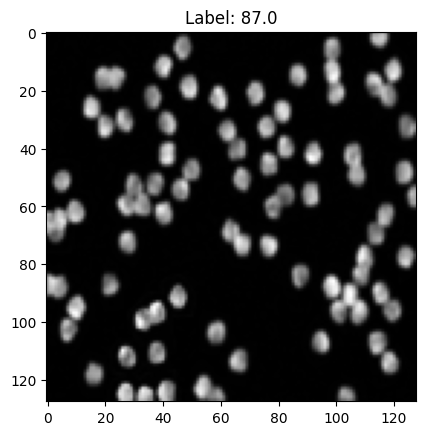

In [ ]:
# Visualize the item
image, label = train_data.__getitem__(0)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
plt.title(f'Label: {label*std_label+mean_label}')
plt.show()

**Model Summary for CNN_2**

In [ ]:
#get the sumamry 
summary(CNN_2, input_size=(1, IMG_HEIGHT, IMG_WIDTH))  # Explicitly set batch_size=1 # channels, height, width )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
            Conv2d-2         [-1, 32, 128, 128]           9,248
            Conv2d-3         [-1, 32, 128, 128]           9,248
         MaxPool2d-4           [-1, 32, 64, 64]               0
           Dropout-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          18,496
            Conv2d-7           [-1, 64, 64, 64]          36,928
            Conv2d-8           [-1, 64, 64, 64]          36,928
         MaxPool2d-9           [-1, 64, 32, 32]               0
          Dropout-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]          73,856
           Conv2d-12          [-1, 128, 32, 32]         147,584
           Conv2d-13          [-1, 128, 32, 32]         147,584
        MaxPool2d-14          [-1, 128,

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15172\4028095504.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x=F.softmax(x)


**Define Loss Function and Optimizer**

In [ ]:
# Define the loss function as Mean Squared Error Loss
criterion = nn.MSELoss()

# Alternatively, you can use Smooth L1 Loss by uncommenting the following line
# criterion = nn.SmoothL1Loss()

# Define the optimizer as Adam with a learning rate of 0.001
optimizer = torch.optim.Adam(CNN_2.parameters(), lr=0.001)

**Define Training Loop with Validation**

In [ ]:
nb_classe=100
def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer, name):

  train_losses, valid_losses = [], []
  # initialize tracker for minimum validation loss
  valid_loss_min = np.inf  # set initial "min" to infinity

  for epoch in range(n_epochs):
      
      train_loss, valid_loss = 0, 0 # monitor losses

      # train the model
      model.train() # prep model for training
      for data, label in train_loader:
          ratio= nb_classe-1+np.exp(1)
          label = torch.tensor([ [np.exp(1)/ratio if i+1==label[j] else 1/ratio for i in range(nb_classe) ] for j in range(data.size(0))])
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.float32)
          label= label.to(device=device, dtype=torch.float32)
          optimizer.zero_grad()
          output=model(data)
          
          loss=criterion(output,label)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * data.size(0) # update running training loss
      
      # validate the model
      model.eval()
      for data, label in valid_loader:
          ratio= nb_classe-1+np.exp(1)
          label = torch.tensor([ [np.exp(1)/ratio if i+1==label[j] else 0 for i in range(nb_classe) ] for j in range(data.size(0))])
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.float32)
          with torch.no_grad():
              output=model( data)
              
              
          loss=criterion(output,label)
          valid_loss += loss.item() * data.size(0)
    
      # calculate average loss over an epoch
      train_loss /= len(train_loader.sampler)
      valid_loss /= len(valid_loader.sampler)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)

      print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

      # save model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), name)
          valid_loss_min = valid_loss

  return train_losses, valid_losses

**Training and Evaluation with Different Learning Rates and Dropout Settings**

In [ ]:
n_epochs = 20 # number of epochs to train the model
lr_values=[0.001]
dropout_conv=[ 0.3]
results={}
for dc in dropout_conv:
    for lr in lr_values:
        train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data) 
        print(f'For the dataset {mask_or_image}, start the experience for the learning rate {lr}, for the dropout_conv {dc}   :')
        name= f'kagglemodel_lr_{lr}_dc_{dc}.pt'
        CNN_2 = KAGGLE_CNN( img_height=IMG_HEIGHT, img_width=IMG_WIDTH, dropout_conv=dc )
        CNN_2.to(device=device) 
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(CNN_2.parameters(), lr=lr)
        train_losses_k, valid_losses_k=training(n_epochs, train_loader, valid_loader, CNN_2, criterion, optimizer, name )
        evaluation( CNN_2, test_loader, criterion)
        results[(lr, dc, mask_or_image)]= train_losses_k , valid_losses_k
        


For the dataset mask, start the experience for the learning rate 0.001, for the dropout_conv 0.3   :


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15172\4028095504.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x=F.softmax(x)


epoch: 1 	training Loss: 0.000051 	validation Loss: 0.000106
validation loss decreased (inf --> 0.000106).  Saving model ...
epoch: 2 	training Loss: 0.000028 	validation Loss: 0.000105
validation loss decreased (0.000106 --> 0.000105).  Saving model ...
epoch: 3 	training Loss: 0.000012 	validation Loss: 0.000103
validation loss decreased (0.000105 --> 0.000103).  Saving model ...
epoch: 4 	training Loss: 0.000009 	validation Loss: 0.000103
validation loss decreased (0.000103 --> 0.000103).  Saving model ...
epoch: 5 	training Loss: 0.000008 	validation Loss: 0.000103
validation loss decreased (0.000103 --> 0.000103).  Saving model ...
epoch: 6 	training Loss: 0.000007 	validation Loss: 0.000103
validation loss decreased (0.000103 --> 0.000103).  Saving model ...
epoch: 7 	training Loss: 0.000006 	validation Loss: 0.000103
epoch: 8 	training Loss: 0.000005 	validation Loss: 0.000103
validation loss decreased (0.000103 --> 0.000103).  Saving model ...
epoch: 9 	training Loss: 0.000005 

ValueError: only one element tensors can be converted to Python scalars

**Plotting Training and Validation Loss over Epochs**

In [ ]:
evaluation( CNN_2, test_loader, criterion)
results[(lr, dc, mask_or_image)]= train_losses_k , valid_losses_k

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15172\4028095504.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x=F.softmax(x)


For the true value  1 the predicted values are  [17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17]
For the true value  5 the predicted values are  [17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17]
For the true value  10 the predicted values are  [17, 17, 47, 17, 47, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17]
For the true value  14 the predicted values are  [17, 60, 47, 17, 17, 17, 17, 17, 17, 13, 17, 17]
For the true value  18 the predicted values are  [17, 99, 17, 17, 17, 99, 99, 17, 17, 99, 47, 17, 17, 99, 99, 47, 99]
For the true value  23 the predicted values are  [77, 17, 17, 17, 17, 17, 17, 17, 17, 99, 47, 17, 17, 99, 99, 99, 17, 99]
For the true value  27 the predicted values are  [99, 17, 99, 17, 17, 77, 99, 17, 17, 17, 17, 99, 99, 99, 99, 17, 17]
For the true value  31 the predicted values are  [17, 17, 17, 17, 99, 17, 77, 77, 99, 77, 17, 47, 17, 99, 17, 99, 17]
For the true value  35 the predicted values are  [77, 99, 65, 99, 17, 77, 17, 99, 99, 99, 

Text(0, 0.5, 'loss value')

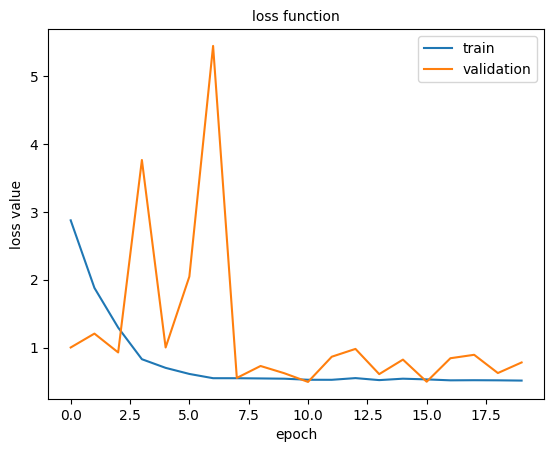

In [ ]:
plt.plot(range(n_epochs), train_losses_k)
plt.plot(range(n_epochs), valid_losses_k)
plt.legend(['train', 'validation'], prop={'size': 10})
plt.title('loss function', size=10)
plt.xlabel('epoch', size=10)
plt.ylabel('loss value', size=10)